This is based on the tutorial of Daniel Bourke: https://www.learnpytorch.io/06_pytorch_transfer_learning/
But rather than efficientnet_b0, which is used in the original tutorial, 
I've implemented transfer learning on ViT image transformer.
I've also changed the way the training loss is calculated at the end of 
the epoch, since the original tutorial calculates an average over the batch
losses during training, and so lags the true loss at the end of the epoch. 
This is problematic for e.g. trying to judge overfitting by comparison to 
a validation set. 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary



In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [14]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb8547003d0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [13]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb85468fa90>,
 ['pizza', 'steak', 'sushi'])

In [12]:
dir(torchvision.models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [13]:

model = torchvision.models.vit_b_16(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 195MB/s]


In [14]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [15]:
# Print a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [16]:
for name, module in model.named_modules():
  print(name, " ***   ", module)

  ***    VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      

In [17]:
# Freeze all base layers in the "features" section of the model instance by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [18]:
# Print a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

current classifier block is linear heads viz:
heads  ***    Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)
heads.head  ***    Linear(in_features=768, out_features=1000, bias=True)
with 768 in and 1000 outoput replace with
: Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=768, out_features=3, bias=True)
    adding dropout to reduce chance of overfitting on our small dataset.


In [19]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
# Remember we defined the model above thus:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# so now going to redefine for this instance of efficientnet_b0, the classifier
# layer
model.heads = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=768,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [20]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [7]:
from typing import Dict, List, Tuple

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  from tqdm.auto import tqdm
  # Create empty results dictionary
  results = {"running_train_loss": [],
      "running_train_acc": [],
      "test_loss": [],
      "test_acc": [],
             "epoch_train_loss": [],
             "epoch_train_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      # running average calculated over batches during training
      running_train_loss, running_train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      epoch_train_loss, epoch_train_acc = test_step(model=model,
          dataloader=train_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"running_train_loss: {running_train_loss:.4f} | "
          f"running_train_acc: {running_train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} |"
          f"epoch_train_loss: {epoch_train_loss:.4f} | "
          f"epoch_train_acc: {epoch_train_acc:.4f} "
      )

      # Update results dictionary
      results["running_train_loss"].append(running_train_loss)
      results["running_train_acc"].append(running_train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["epoch_train_loss"].append(epoch_train_loss)
      results["epoch_train_acc"].append(epoch_train_acc)

  # Return the filled results at the end of the epochs
  return results

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | running_train_loss: 0.8501 | running_train_acc: 0.6328 | test_loss: 0.5255 | test_acc: 0.9167 |epoch_train_loss: 0.5362 | epoch_train_acc: 0.9062 
Epoch: 2 | running_train_loss: 0.4355 | running_train_acc: 0.8867 | test_loss: 0.3337 | test_acc: 0.9280 |epoch_train_loss: 0.2833 | epoch_train_acc: 0.9453 
Epoch: 3 | running_train_loss: 0.2626 | running_train_acc: 0.9375 | test_loss: 0.2497 | test_acc: 0.9479 |epoch_train_loss: 0.2018 | epoch_train_acc: 0.9492 
Epoch: 4 | running_train_loss: 0.1978 | running_train_acc: 0.9453 | test_loss: 0.2119 | test_acc: 0.9583 |epoch_train_loss: 0.1631 | epoch_train_acc: 0.9531 
Epoch: 5 | running_train_loss: 0.2389 | running_train_acc: 0.9570 | test_loss: 0.2040 | test_acc: 0.8873 |epoch_train_loss: 0.2978 | epoch_train_acc: 0.8438 
[INFO] Total training time: 1977.133 seconds


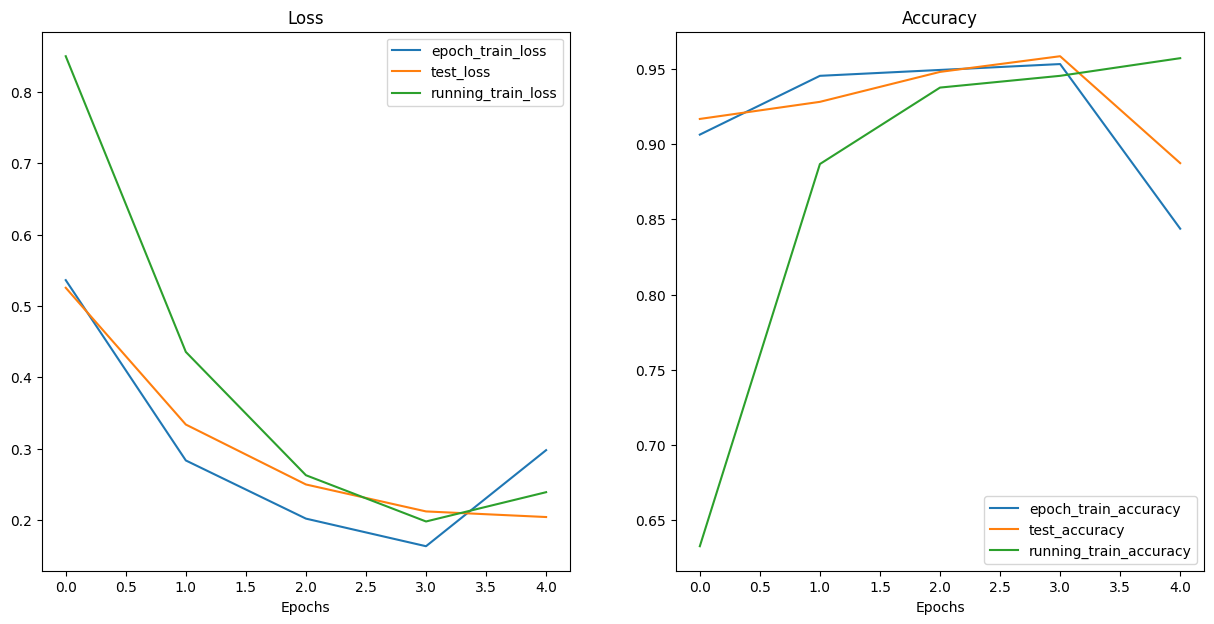

In [32]:
# the variable "results" contains the average of all batches in
# an epoch. I.e. not a true representation of the loss/accuracy
# at the end of the epoch, but rather a running average over the epoch. But
# here also added the true loss/accuracy at the end of the epoch
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["epoch_train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["epoch_train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["epoch_train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="epoch_train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.plot(epochs, results["running_train_loss"], label="running_train_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="epoch_train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.plot(epochs, results["running_train_acc"], label="running_train_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(results)

epoch_train_accuracy and epoch_train_loss are the accuracy and loss calculated on the whole training set at the end of the epoch, which is marginally different from the running average calculated over all batches during the training loop, since the latter are calculated during the epoch, not at the end of the epoch, the last batch notwithstanding.

In [34]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

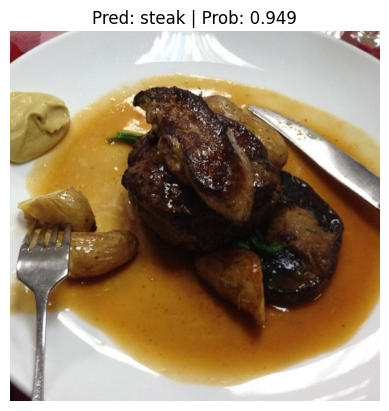

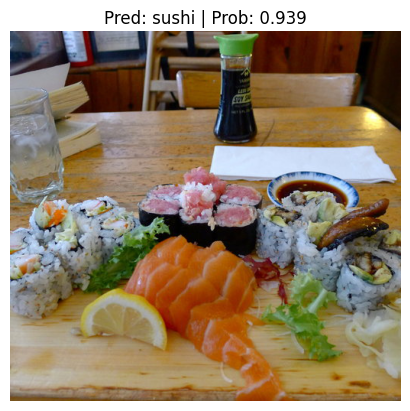

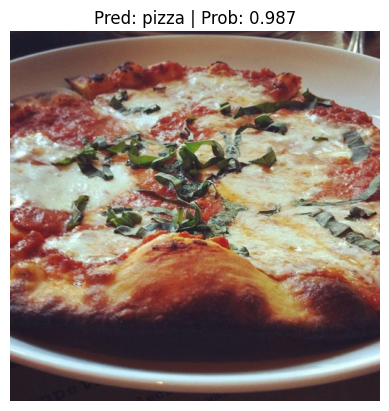

In [27]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [37]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

data/04-pizza-dad.jpeg already exists, skipping download.


NameError: ignored

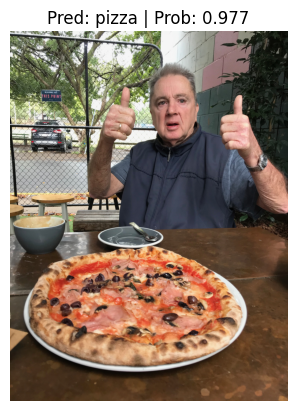

In [29]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [30]:
# save current model.
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive

Mounted at /content/drive
MyDrive


In [31]:
!ls /content/drive/MyDrive/Colab\ Notebooks

 basic_conv_nets.ipynb
 Colab_binary_classification_default_initialisations.ipynb
 Colab_binary_classification_kaiminghe_initialisations.ipynb
 Colab_ConcentricCirclesBinaryClassification_default_init.ipynb
 colab_GCN_GAT_inialization_tests.ipynb
'Copy of Copy of transfer_learning_basics.ipynb'
'Copy of Untitled0.ipynb'
 FashionMNIST_DenseOnly_ComparedTo_CNNmodels.ipynb
 hugging_face
 models_transfer_learning
 multiclass_classification_mini_batch_better_init.ipynb
 PyG_GCNConv_tutorial_embedding_classification.ipynb
 PytorchTensorFunctions.ipynb
 transfer_learning_basics.ipynb
 transfer_learning_basics_reloading_original_model_AdamW.ipynb
 transfer_learning_basics_reloading_original_model_AdamW_second_repeat.ipynb
 transfer_learning_basics_reloading_original_model.ipynb
 transfer_learning_basics_reloading_original_model_repeat_with_Adam.ipynb
 transfer_learning_ViT.ipynb
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipynb
 Untitled5.ipynb
 Untitled6.ipy

In [32]:
# save current model.
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')



# 1. Create models directory
MODEL_PATH = Path("/content/drive/MyDrive/Colab Notebooks/models_transfer_learning")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pizza_steak_sushi_transfer_ViT_5epochs_classifier.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the parameters
           f=MODEL_SAVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MODEL_SAVE_PATH: /content/drive/MyDrive/Colab Notebooks/models_transfer_learning/pizza_steak_sushi_transfer_efficientnet_b0_5epochs_classifier.pt


In [33]:
!ls /content/drive/MyDrive/Colab\ Notebooks/models_transfer_learning

pizza_steak_sushi_transfer_efficientnet_b0_5epochs_classifier.pt


In [34]:
# training another two epochs, with the last Conv2D/batch norm/siLU layer
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=2,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | running_train_loss: 0.1271 | running_train_acc: 0.9609 | test_loss: 0.1600 | test_acc: 0.9375 |epoch_train_loss: 0.1354 | epoch_train_acc: 0.9609 
Epoch: 2 | running_train_loss: 0.1213 | running_train_acc: 0.9648 | test_loss: 0.1816 | test_acc: 0.9176 |epoch_train_loss: 0.1154 | epoch_train_acc: 0.9609 
[INFO] Total training time: 906.592 seconds


In [36]:
MODEL_NAME = "pizza_steak_sushi_transfer_ViT_7epochs_classifier.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the parameters
           f=MODEL_SAVE_PATH)

MODEL_SAVE_PATH: /content/drive/MyDrive/Colab Notebooks/models_transfer_learning/pizza_steak_sushi_transfer_ViT_7epochs_classifier.pt


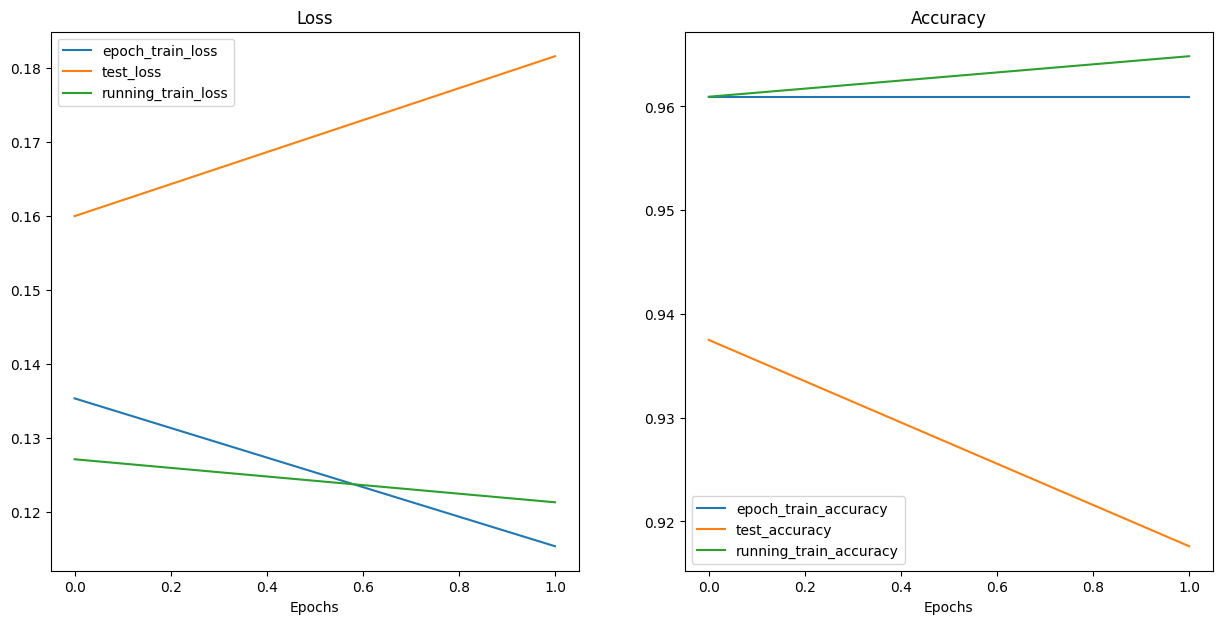

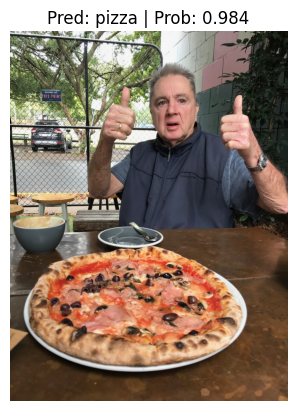

In [35]:
plot_loss_curves(results)
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

looking very much like overfitting! Even with massive dropout! Try again with AdamW, with default regularisation parameter.

In [19]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [20]:
model_adamw = torchvision.models.vit_b_16(weights=weights).to(device)


In [22]:
# Freeze all base layers in the "features" section of the model instance by setting requires_grad=False
for param in model_adamw.parameters():
    param.requires_grad = False

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
# Remember we defined the model above thus:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# so now going to redefine for this instance of efficientnet_b0, the classifier
# layer
model_adamw.heads = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=768,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [24]:
summary(model_adamw,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [25]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [28]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b45e46b2440>,
 ['pizza', 'steak', 'sushi'])

In [29]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_adamw.parameters(), lr=0.001)

In [30]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model_adamw,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | running_train_loss: 0.8501 | running_train_acc: 0.6328 | test_loss: 0.5255 | test_acc: 0.9167 |epoch_train_loss: 0.5362 | epoch_train_acc: 0.9062 
Epoch: 2 | running_train_loss: 0.4355 | running_train_acc: 0.8867 | test_loss: 0.3337 | test_acc: 0.9280 |epoch_train_loss: 0.2834 | epoch_train_acc: 0.9453 
Epoch: 3 | running_train_loss: 0.2627 | running_train_acc: 0.9375 | test_loss: 0.2497 | test_acc: 0.9479 |epoch_train_loss: 0.2018 | epoch_train_acc: 0.9492 
Epoch: 4 | running_train_loss: 0.1978 | running_train_acc: 0.9453 | test_loss: 0.2119 | test_acc: 0.9583 |epoch_train_loss: 0.1631 | epoch_train_acc: 0.9531 
Epoch: 5 | running_train_loss: 0.2389 | running_train_acc: 0.9570 | test_loss: 0.2041 | test_acc: 0.8873 |epoch_train_loss: 0.2978 | epoch_train_acc: 0.8438 
[INFO] Total training time: 1861.361 seconds


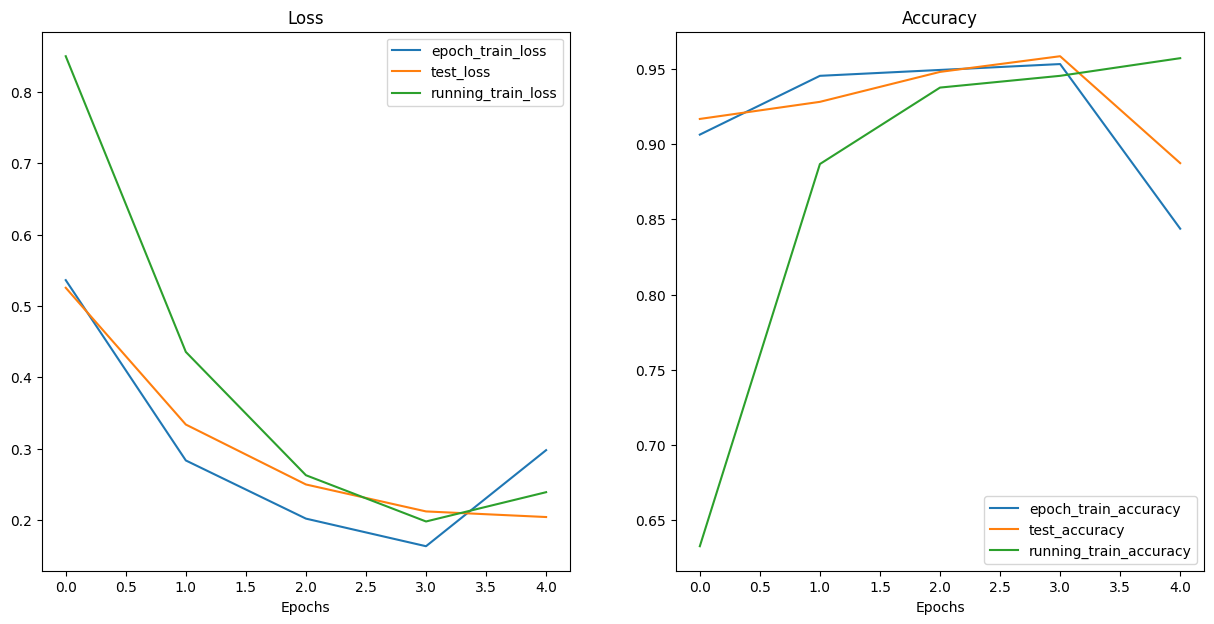

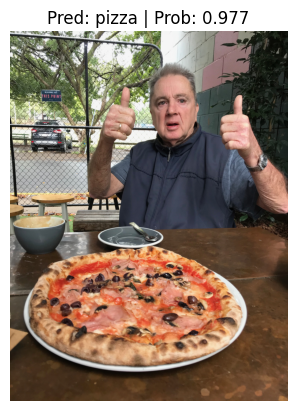

In [38]:
plot_loss_curves(results)
pred_and_plot_image(model=model_adamw,
                    image_path=custom_image_path,
                    class_names=class_names)

In [39]:
# save current model.
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive


In [40]:
# save current model.
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')



# 1. Create models directory
MODEL_PATH = Path("/content/drive/MyDrive/Colab Notebooks/models_transfer_learning")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pizza_steak_sushi_transfer_ViT_5epochs_adamw_classifier.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the parameters
           f=MODEL_SAVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MODEL_SAVE_PATH: /content/drive/MyDrive/Colab Notebooks/models_transfer_learning/pizza_steak_sushi_transfer_ViT_5epochs_adamw_classifier.pt


NameError: ignored